In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Preprocess

In [2]:
data = pd.read_csv("train.csv", dtype = {'VisitNumber': str, 'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

In [3]:
#Leave out Upc
data.drop('Upc', axis = 1, inplace = True)

In [4]:
data.info() #647054 rows × 6 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 6 columns):
TripType                 647054 non-null category
VisitNumber              647054 non-null object
Weekday                  647054 non-null category
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 21.0+ MB


### Missing Value

In [5]:
data.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

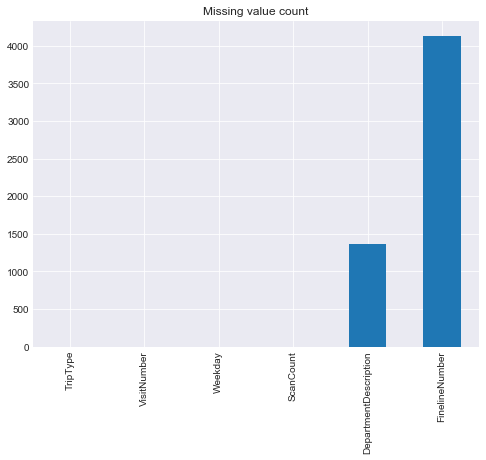

In [6]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
data.isnull().sum().plot.bar()
plt.title("Missing value count")
plt.show()

(array([  6.,   0.,   0.,   1.,   0.,   0.,  84.,   0.,   0.,  63.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

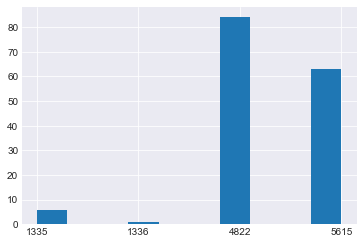

In [7]:
data[(data['DepartmentDescription'].isnull()) | (data['FinelineNumber'].isnull())] #4129 rows
pharmacy_null = data[((data['FinelineNumber'].isnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] #2768 rows
pharmacy_notnull = data[((data['FinelineNumber'].notnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] 
plt.hist(pharmacy_notnull['FinelineNumber'])

In [8]:
#Deal with missing FinelineNumber in 'PHARMACY RX' with replacement of '9999'
phar_missing_index = list(data[(data['DepartmentDescription'] == 'PHARMACY RX') & (data['FinelineNumber'].isnull())].index)
for i in phar_missing_index:
    data["FinelineNumber"].iloc[i] = "9999"

In [9]:
data.dropna(inplace = True) 

In [10]:
trip = list(data[['VisitNumber', 'TripType']].drop_duplicates()['TripType'])

In [11]:
data.drop('TripType', axis = 1, inplace = True)#(645693, 5)

### Spreading features

#### 1. FinelineNumber

In [12]:
data['VisitNumber'] = data['VisitNumber'].astype(int, copy=False)

In [13]:
len(data['VisitNumber'].unique())

95516

In [14]:
group_visit_fineline = data.groupby(['VisitNumber','FinelineNumber']).agg({'FinelineNumber':'count'})

In [15]:
fn = group_visit_fineline.unstack() 

In [16]:
fn = fn['FinelineNumber']
fn.fillna(0, inplace= True)

In [17]:
#finelineNumber columns
fn_seq = list(fn.columns)

In [18]:
X = np.array(fn) #(95516, 5196)

In [19]:
#X[X > 0] = 1

In [20]:
#visitNumber sequence
vn_seq = list(fn.index)

#### 2. Weekday

In [21]:
day = pd.get_dummies(data[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

In [22]:
day.drop('VisitNumber', axis = 1, inplace = True)

In [23]:
day.head()
day = day[['Weekday_Sunday', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday']]

In [24]:
day_seq= list(day.columns)

In [25]:
X_day = np.array(day)

In [26]:
temp = np.concatenate((X, X_day), axis=1)

In [27]:
temp.shape

(95516, 5203)

#### 3. DepartmentDescription

In [28]:
dept = data.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})
dept = dept.unstack()
dept = dept['DepartmentDescription']
dept.fillna(0, inplace= True)

In [29]:
dept_seq= list(dept.columns)

In [30]:
department = np.array(dept) 
#department[department > 0] = 1

In [31]:
final = np.concatenate((temp, department), axis=1) #(95516, 5271)

In [32]:
final = final.astype(np.float32, copy=False)#(95516, 5271)

#### 4. ScanCount

In [33]:
sc = data.groupby(['VisitNumber'], as_index = False).agg({'ScanCount':'sum'})

In [34]:
def scanlevel(row):
    if row <0 :
        return 'return'
    elif row<5:
        return "few"
    elif row <15:
        return "medium"
    else:
        return "many"

In [35]:
sc["sc_level"] = sc["ScanCount"].apply(scanlevel)

In [36]:
sc.head()

,VisitNumber,ScanCount,sc_level
0,5,-1,return
1,7,2,few
2,8,27,many
3,9,3,few
4,10,3,few


In [37]:
sc_dummy = pd.get_dummies(sc[["VisitNumber", "sc_level"]], columns = ["sc_level"])

In [38]:
sc_dummy = sc_dummy[["VisitNumber", 'sc_level_return','sc_level_few','sc_level_medium','sc_level_many']]

In [39]:
sc_dummy.drop("VisitNumber", axis =1, inplace = True)

In [40]:
sc_seq = list(sc_dummy.columns)

In [41]:
sc_array = np.array(sc_dummy)

In [42]:
df = np.concatenate((final, sc_array), axis=1) #(95516, 5275)

In [63]:
header = [] #5275
header.extend(fn_seq)
header.extend(day_seq)
header.extend(dept_seq)
header.extend(sc_seq)

['0',
 '1',
 '10',
 '100',
 '1000',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '101',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '102',
 '1020',
 '1021',
 '1022',
 '1023',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '103',
 '1030',
 '1031',
 '1032',
 '1033',
 '1034',
 '1035',
 '1037',
 '1039',
 '104',
 '1040',
 '1041',
 '1042',
 '1043',
 '1045',
 '1046',
 '1048',
 '105',
 '1050',
 '1052',
 '1053',
 '1056',
 '1057',
 '1058',
 '1059',
 '106',
 '1060',
 '1061',
 '1062',
 '1063',
 '1064',
 '1065',
 '1066',
 '1067',
 '1069',
 '107',
 '1070',
 '1071',
 '1072',
 '1073',
 '1074',
 '1075',
 '1077',
 '1078',
 '108',
 '1080',
 '1081',
 '1084',
 '1085',
 '1086',
 '109',
 '1090',
 '1094',
 '1096',
 '1097',
 '1099',
 '11',
 '110',
 '1100',
 '1101',
 '1102',
 '1103',
 '1104',
 '1105',
 '1106',
 '1107',
 '1108',
 '1109',
 '111',
 '1110',
 '1111',
 '1112',
 '1113',
 '1114',
 '1115',
 '1116',
 '1117',
 '1118',
 '111

In [47]:
from scipy import sparse
X_sparse = sparse.csr_matrix(df)

In [59]:
t = np.array(trip)
t = t.astype('int')
tt =t[:,np.newaxis]

In [62]:
np.savetxt("triptype.csv", tt, delimiter = ",")

In [ ]:
#scipy.sparse.save_npz('df_sparse_matrix.npz', X_sparse)
#source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html